# Cell density and composition

### Cell density

In [1]:
from voxcell import VoxelData, RegionMap
import bluepy
from bluepy.v2.enums import Cell
from voxcell.nexus.voxelbrain import Atlas
import pandas as pd
import numpy as np

In [2]:
circuit_path = '/mnt/circuits/O1/20181114/CircuitConfig'
atlas_path = '/mnt/entities/dev/atlas/O1-243/'

In [9]:
circuit = bluepy.Circuit(circuit_path)

In [12]:
atlas = Atlas.open(atlas_path)
brain_regions = atlas.load_data('brain_regions')
hierarchy = atlas.load_hierarchy()

In [13]:
regions = ['CA1', 'SLM', 'SR', 'SP', 'SO']
df = pd.DataFrame(index=regions, columns=np.arange(7))
df.head()

,0,1,2,3,4,5,6
CA1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SLM,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SP,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SO,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
scale = 1000000

for idx in range(7):
    mod = []
    ids1 = hierarchy.collect('acronym', 'mc'+str(idx), 'id')
    gids1 = circuit.v2.cells.ids({Cell.REGION: '@mc'+str(idx)+'.*'})
    
    # Neurons in CA1
    mod.append(len(gids1) * scale / brain_regions.volume(ids1))
    
    # SLM neurons in SLM
    ids2 = hierarchy.collect('acronym', 'mc'+str(idx)+';SLM', 'id')
    ids = ids1.intersection(ids2)
    gids2 = circuit.v2.cells.ids('SLM')
    gids = np.intersect1d(gids1, gids2)
    mod.append(len(gids) * scale / brain_regions.volume(ids))
    
    # SR neurons in SR
    ids2 = hierarchy.collect('acronym', 'mc'+str(idx)+';SR', 'id')
    ids = ids1.intersection(ids2)
    gids2 = circuit.v2.cells.ids('SR')
    gids = np.intersect1d(gids1, gids2)
    mod.append(len(gids) * scale / brain_regions.volume(ids))
    
    # SP neurons in SP
    ids2 = hierarchy.collect('acronym', 'mc'+str(idx)+';SP', 'id')
    ids = ids1.intersection(ids2)
    gids2 = circuit.v2.cells.ids('SP')
    gids = np.intersect1d(gids1, gids2)
    mod.append(len(gids) * scale / brain_regions.volume(ids))
    
    # SO neurons in SO
    ids2 = hierarchy.collect('acronym', 'mc'+str(idx)+';SO', 'id')
    ids = ids1.intersection(ids2)
    gids2 = circuit.v2.cells.ids('SO')
    gids = np.intersect1d(gids1, gids2)
    mod.append(len(gids) * scale / brain_regions.volume(ids))
    
    df[idx] = mod
                            
df.head()

,0,1,2,3,4,5,6
CA1,25.613276,27.007924,25.168462,26.089881,25.703819,26.261299,25.358019
SLM,0.044092,0.000000,0.000000,0.043516,0.000000,0.043802,0.043516
SR,0.070862,0.093861,0.118889,0.093249,0.000000,0.093861,0.093249
SP,279.651675,293.035480,273.635153,283.833768,280.442400,286.246167,276.218451
SO,0.583567,1.275412,0.939923,0.921517,0.811626,0.734328,0.767931


In [16]:
means = df.mean(axis=1)
stds = df.std(axis=1)
df['mean'] = means
df['std'] = stds
df.head()

,0,1,2,3,4,5,6,mean,std
CA1,25.613276,27.007924,25.168462,26.089881,25.703819,26.261299,25.358019,25.886097,0.624810
SLM,0.044092,0.000000,0.000000,0.043516,0.000000,0.043802,0.043516,0.024989,0.023376
SR,0.070862,0.093861,0.118889,0.093249,0.000000,0.093861,0.093249,0.080567,0.038142
SP,279.651675,293.035480,273.635153,283.833768,280.442400,286.246167,276.218451,281.866156,6.511359
SO,0.583567,1.275412,0.939923,0.921517,0.811626,0.734328,0.767931,0.862043,0.218226


### Composition per layer

In [17]:
from voxcell import VoxelData, RegionMap
import bluepy
from bluepy.v2.enums import Cell
from voxcell.nexus.voxelbrain import Atlas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
mtypes = circuit.v2.cells.mtypes

In [19]:
columns = range(7)

In [20]:
composition = pd.DataFrame(index=mtypes, columns=columns)
composition.head()

,0,1,2,3,4,5,6
SP_AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SO_OLM,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SP_CCKBC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SO_BS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SO_BP,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
for column in columns:
    for mtype in mtypes:
        composition[column][mtype] = len(circuit.v2.cells.ids(group={Cell.MTYPE: mtype, Cell.REGION: '@mc'+str(column)+'.*'}))
        
composition.head()

,0,1,2,3,4,5,6
SP_AA,14,11,10,15,5,13,12
SO_OLM,6,21,13,14,12,12,10
SP_CCKBC,32,26,16,30,20,29,42
SO_BS,5,6,5,4,3,1,4
SO_BP,0,0,0,0,1,1,0


In [22]:
means = composition.mean(axis=1)
stds = composition.std(axis=1)
composition['mean'] = means
composition['std'] = stds
composition.head()

,0,1,2,3,4,5,6,mean,std
SP_AA,14,11,10,15,5,13,12,11.428571,3.309438
SO_OLM,6,21,13,14,12,12,10,12.571429,4.540820
SP_CCKBC,32,26,16,30,20,29,42,27.857143,8.454359
SO_BS,5,6,5,4,3,1,4,4.000000,1.632993
SO_BP,0,0,0,0,1,1,0,0.285714,0.487950


### El ratio

In [23]:
rows = ['EXC', 'INH', 'EXC%']
ratio = pd.DataFrame(index=rows, columns=np.arange(7))
ratio.head()

,0,1,2,3,4,5,6
EXC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
INH,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EXC%,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
for column in columns:
    for target in ['EXC', 'INH']:
        ratio[column][target] = len(circuit.v2.cells.ids(group={Cell.SYNAPSE_CLASS: target, Cell.REGION: '@mc'+str(column)+'.*'}))
        
ratio.head()

,0,1,2,3,4,5,6
EXC,2361,2508,2335,2448,2407,2451,2350
INH,195,205,160,190,175,187,214
EXC%,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
ratio.loc['EXC%'] = ratio.loc['EXC']*100/(ratio.loc['EXC']+ratio.loc['INH'])
ratio

,0,1,2,3,4,5,6
EXC,2361,2508,2335,2448,2407,2451,2350
INH,195,205,160,190,175,187,214
EXC%,92.3709,92.4438,93.5872,92.7976,93.2223,92.9113,91.6537


In [26]:
means = ratio.mean(axis=1)
stds = ratio.std(axis=1)
ratio['mean'] = means
ratio['std'] = stds
ratio.head()

,0,1,2,3,4,5,6,mean,std
EXC,2361,2508,2335,2448,2407,2451,2350,2408.571429,63.704676
INH,195,205,160,190,175,187,214,189.428571,18.063380
EXC%,92.3709,92.4438,93.5872,92.7976,93.2223,92.9113,91.6537,92.712386,0.630046


### Cells positions across layers

In [27]:
df = circuit.v2.cells.positions(group={'$target': 'PV', Cell.REGION: '@mc2.*'})
df.head()

/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(470, True) will return an array of dtype('bool')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


,x,y,z
16897,307.309152,183.112256,428.667980
16929,527.128856,208.813164,701.847876
16953,416.277892,197.418862,788.005761
16957,259.320300,213.971620,703.004457
16979,336.686214,211.559442,536.267182


In [28]:
x = df['x'].values
y = df['y'].values

/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


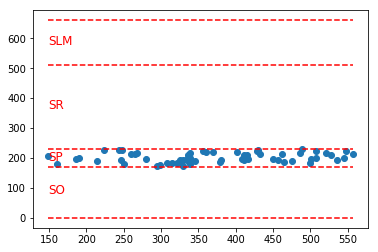

In [29]:
fig, ax = plt.subplots()
ax.scatter(x,y)
layer_heights = (0, 170, 230, 510, 660)
heights = (80, 190, 365, 580)
layers = ('SO', 'SP', 'SR', 'SLM')
ax.hlines(layer_heights, x.min(), x.max(), linestyle='--', colors='r')
for layer, height in zip(layers, heights):
    ax.text(x.min(), height, layer, fontsize=12, color='r')
fig.show()